In [2]:
%matplotlib inline
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

https://data.oecd.org/interest/long-term-interest-rates.htm

Esta data es sobre los bonos cupon cero (cetes) intereses que emite el bono

In [3]:
pdi_df = pd.read_csv('data/DPI.csv').rename(columns={'Value':'pdi'})
pdi_df['TIME'] = pd.to_datetime(pdi_df['TIME'],format='%Y-%m')
pdi_df

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,pdi,Flag Codes
0,IRL,LTINT,TOT,PC_PA,M,1970-12-01,10.018280,NaN
1,IRL,LTINT,TOT,PC_PA,M,1971-01-01,9.977638,NaN
2,IRL,LTINT,TOT,PC_PA,M,1971-02-01,10.008120,NaN
3,IRL,LTINT,TOT,PC_PA,M,1971-03-01,9.662662,NaN
4,IRL,LTINT,TOT,PC_PA,M,1971-04-01,9.550896,NaN
...,...,...,...,...,...,...,...,...
17694,EST,LTINT,TOT,PC_PA,M,2021-10-01,0.180000,NaN
17695,EST,LTINT,TOT,PC_PA,M,2021-11-01,0.200000,NaN
17696,EST,LTINT,TOT,PC_PA,M,2021-12-01,0.110000,NaN
17697,EST,LTINT,TOT,PC_PA,M,2022-01-01,0.310000,NaN


In [4]:
# revisemos cuantos registros por país hay en el dataset
pdi_df['LOCATION'].value_counts()

USA     828
CAN     807
BEL     807
CHE     806
DEU     791
ZAF     783
NLD     758
GBR     747
FRA     747
AUS     633
EA19    627
NZL     626
IRL     615
ESP     506
NOR     447
SWE     424
DNK     422
FIN     410
JPN     399
AUT     387
ITA     373
PRT     345
ISL     341
LUX     306
ISR     303
GRC     296
HUN     278
CZE     264
SVK     258
KOR     258
POL     255
LVA     254
LTU     254
SVN     240
RUS     234
COL     231
CHL     202
MEX     192
IND     123
CRI     101
EST      21
Name: LOCATION, dtype: int64

,pdi
TIME,
2021-06-01,1.52
2021-07-01,1.32
2021-08-01,1.28
2021-09-01,1.37
2021-10-01,1.58
2021-11-01,1.56
2021-12-01,1.47
2022-01-01,1.76
2022-02-01,1.93


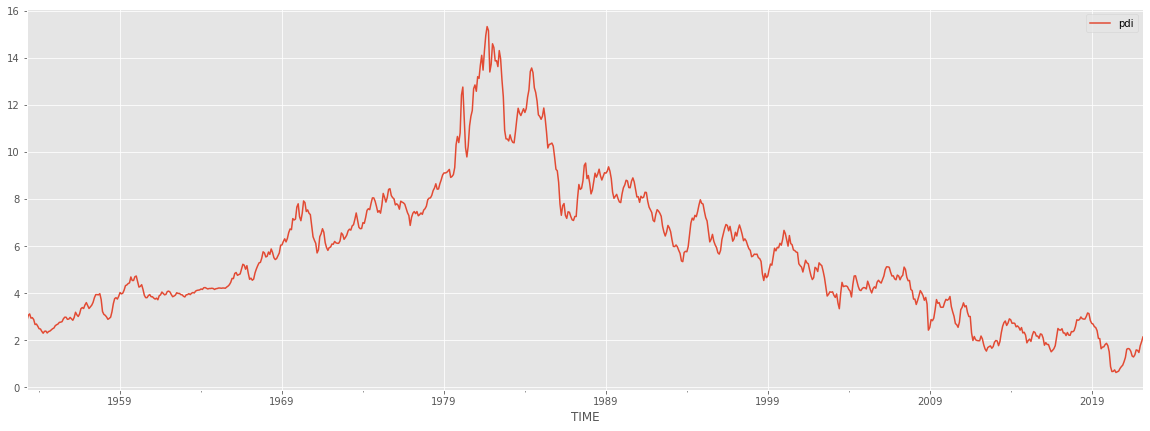

In [5]:
country = 'USA'
Xt = 'pdi'

#seleccionamos un pais y la la pdi = tasa de interes, ordeno por tiempo, y el indice ahora es el time
series_df = pdi_df[pdi_df['LOCATION']==country][[Xt,'TIME']].sort_values('TIME').set_index('TIME')
series_df.plot(figsize=(20,7))
series_df.tail(10)

C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


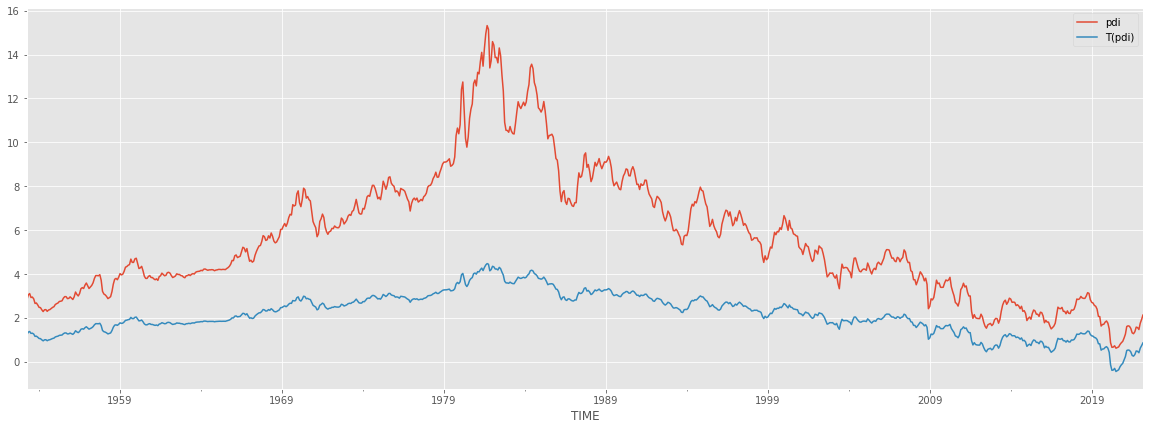

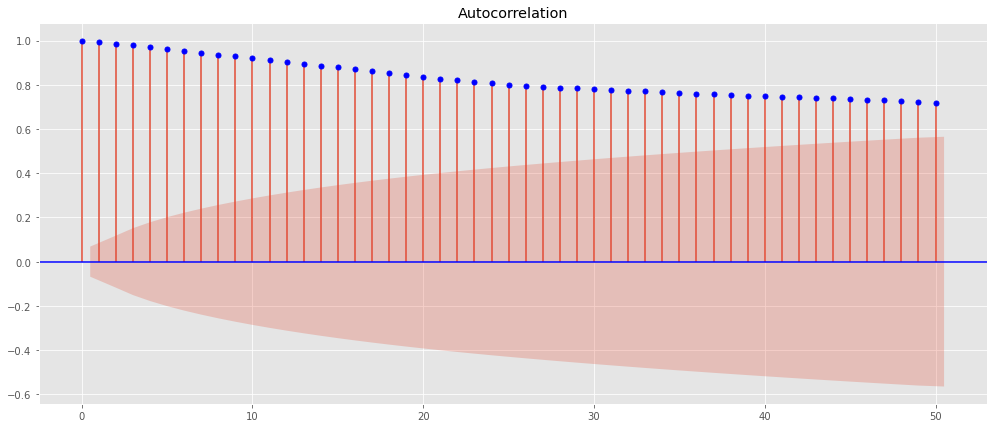

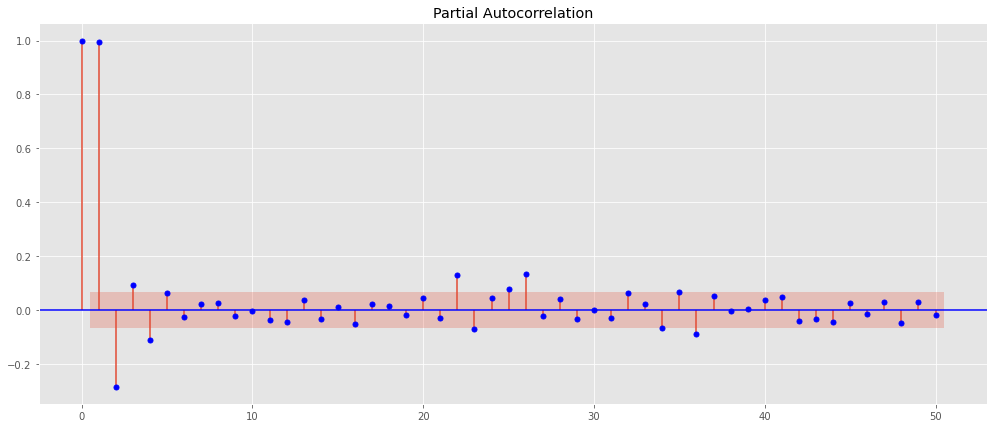

In [7]:
# tranformada de boz cox para estabilizar la varianza 
# standarize es para restar media y dividir entre la desviacion estandar
# fit para ajustar la columna 
box_cox_transform = PowerTransformer(method='box-cox', standardize = False, copy = True).fit(series_df[['pdi']])
# luego esa cosa de arriba es un objeto que se entrenó con la seriie original, entonces voy a crear 
# una nueva columna donde haga la transformacion a la serie original con el nombre 'T(pdi)'
bc_transformed_df = pd.DataFrame(box_cox_transform.transform(series_df[['pdi']]), columns=['T(pdi)'])

# el tiempo va a ser el index original
bc_transformed_df['TIME'] = series_df.index
bc_transformed_df.set_index('TIME',inplace=True)

# copio la columna de la tasa de interes original para despues compararlos con los de la transformacion
series_df['T(pdi)'] = bc_transformed_df['T(pdi)'].copy()
series_df[['pdi','T(pdi)']].plot(figsize=(20,7))


#autocorrelogramas simple y parcial 
lags=50 
AR_1_CFS = pd.DataFrame([acf(series_df['T(pdi)'],nlags=lags),\
                         pacf(series_df['T(pdi)'],nlags=lags)]).transpose()
AR_1_CFS.columns = ['acf_AR_1','pacf_AR_1']

plt.style.use('ggplot')
plt.figsize=(15,10)
fig = plot_acf(series_df['T(pdi)'],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
fig = plot_pacf(series_df['T(pdi)'],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
plt.show()

a pesar de haber estabilizado la varianza, no logramos estabilizar la media, pues la serie se ve claramente como sube y luego baja, entonces para esabilizar la media lo hacemos mediante diferencias

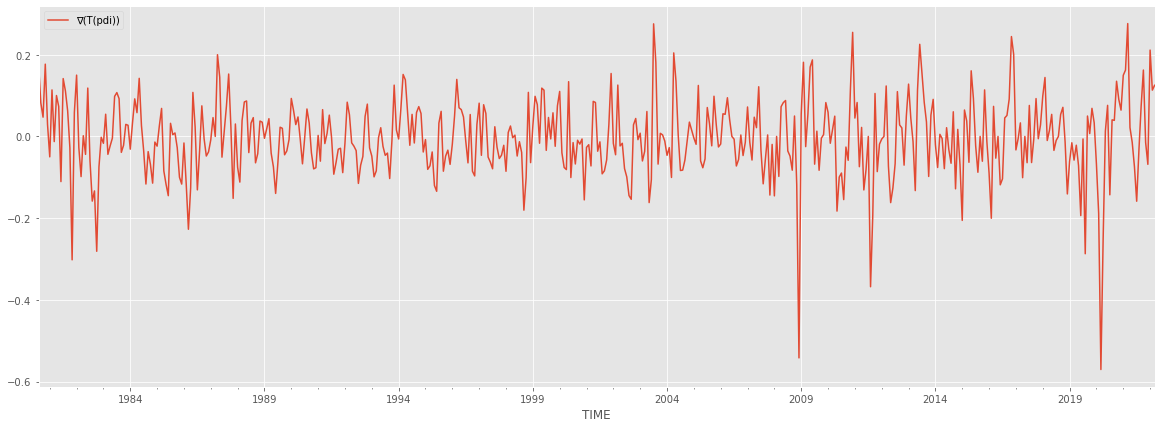

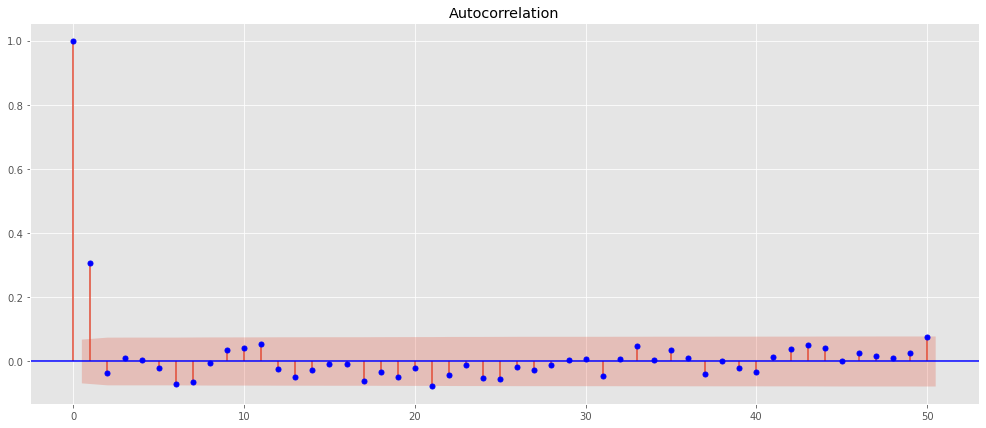

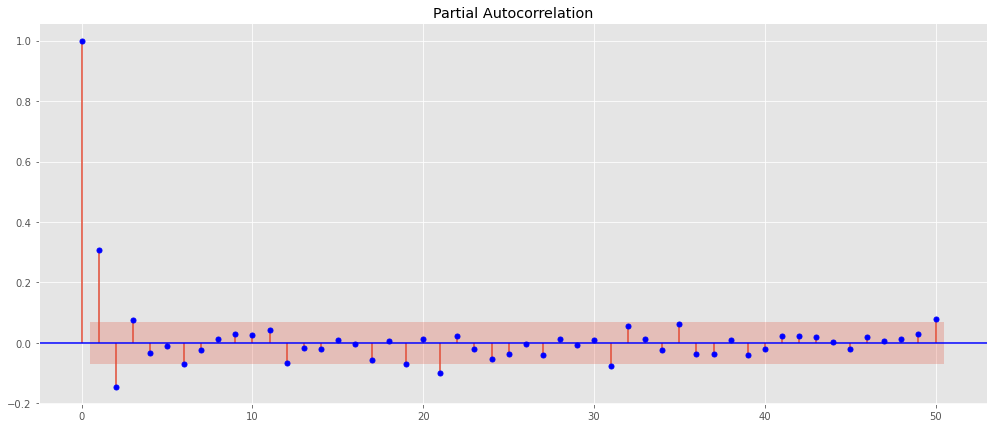

In [11]:
# el costo de hacer diferencias es que perdemos n datos donde "n" es el valor de la diferencia

# 1 diferencia sobre la columna de la transformada y la pongo en una nueva columna 
series_df['∇(T(pdi))'] = series_df['T(pdi)'].diff()
series_df.tail(500)[['∇(T(pdi))']].plot(figsize=(20,7)) # graficamos los ultimos valores


#graficamos los autocorrelogramas de la nabla 
plt.style.use('ggplot')
plt.figsize=(15,10)
fig = plot_acf(series_df['∇(T(pdi))'].dropna(),lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
fig = plot_pacf(series_df['∇(T(pdi))'].dropna(),lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
plt.show()

como el autocorrelograma parcial se ve "alternado", es decir que sube y baja (las correlaciones), podemos deducir que podría ser una media movil, para elegir el orden de la media movil, nos lo da el correlograma simple

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# el modelo se empieza a partir de la primera entrada porque perdimos el primer dato de las diferencias
or_ar = 0
or_ma = 1
d = 0
# trend = 'nc' quiere decir que no hay phi_0
pdi_model = SARIMAX(series_df['∇(T(pdi))'][1:], order=(or_ar, d, or_ma), seasonal_order = (0, 0, 0, 0),).fit(trend='nc') 
pdi_model.summary()

C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              ∇(T(pdi))   No. Observations:                  827
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 932.982
Date:                Thu, 28 Apr 2022   AIC                          -1861.964
Time:                        17:45:17   BIC                          -1852.528
Sample:                    05-01-1953   HQIC                         -1858.345
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3849      0.025     15.253      0.000       0.335       0.434
sigma2         0.0061      0.000     35.616      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               863.63
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               4.18   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

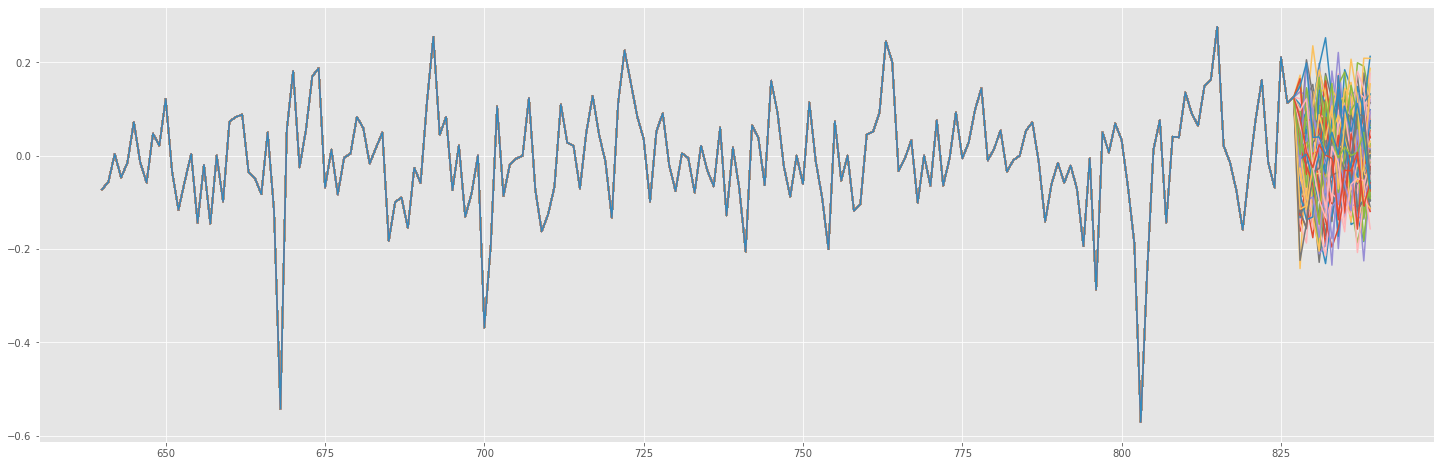

In [16]:
import statsmodels.api as sm

# simular diferentes medias moviles hacia delante
ma = pdi_model.params[0] # parametro de la media movil, es decir, el theta que ajusta a la MA
sigma = np.sqrt(pdi_model.params[1]) # desviación estandar del modelo
ma = np.array([ma]) #covertir en array
nsample = 12 #predecimos 12 puntos hacia delante
simulations = 100 # numero de simulaciones

# generar rango de fechas (12 hacia el futuro), freq, es la frecuencia, d-dia, m-mes, y-año
# compresion de lista para generar las fechas correctas
future_dates = [str(date)[:7]+'-01' for date in pd.date_range(start='2022-04-01', periods=nsample, freq='M')]
# las fechas las convierto en un DF, es decir un df con una columna donde esten las fechas a predecir
scenarios_df = pd.DataFrame(future_dates,columns=['TIME'])

nabbla_columns = []
for i in range(0,simulations): # 100 simulaciones 
    scenarios_df['∇(T(pdi))_'+str(i+1)] = sm.tsa.arma_generate_sample(np.r_[1, np.array([0, 0])], np.r_[1, ma], #simu de un MA(1)
                                                                      scale=sigma, #con sigma del modelo 
                                                                      nsample = nsample) #con doce predicciones al futuro
    nabbla_columns.append('∇(T(pdi))_'+str(i+1))

# las simulaciones anteriores de guardaran en la tabla de los escenarios , es decir, 100 columnas de trayectorias simuladas
scenarios = []
for col in nabbla_columns:
    scenarios.append(list(series_df['∇(T(pdi))'])+list(scenarios_df[col]))

scenarios_df = pd.DataFrame(scenarios).transpose()
scenarios_df.columns = nabbla_columns
scenarios_df['TIME'] = list(series_df.index)+list(future_dates)
scenarios_df.set_index('TIME',inplace=True)
scenarios_df = pd.merge(series_df.reset_index(), scenarios_df.reset_index(), how='right')
scenarios_df[nabbla_columns].tail(200).plot(figsize=(25,8),legend=False)

Muy bonito y todo, pero tenemos que regresar todas las operaciones para conocer las verdaderas predicciones, es decir si hicimos una diferencia, ahoraa hago una suma, y aplicar la funcion inversa de box cox para recueperar el valor correcto de la serie 

<AxesSubplot:>

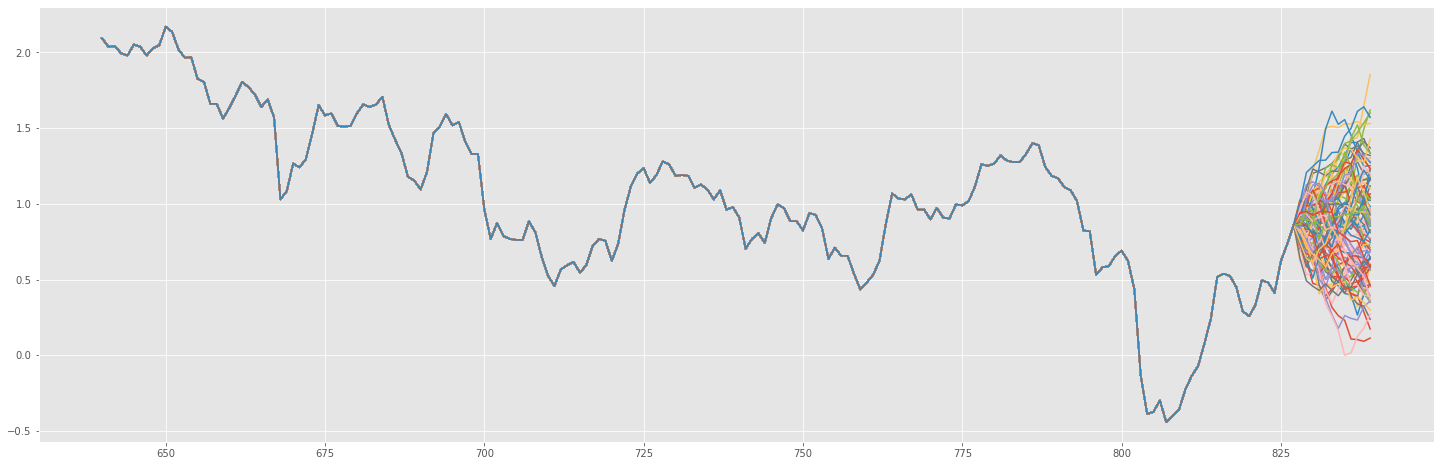

In [18]:
# este codigo hace las sumas de las T(pdi)_t con la nabla_t+1 para calcular el el T(pdi) en t+1 y eso para las 
# 100 nablas distintas que se crearon  

first_value = scenarios_df['T(pdi)'].iloc[0]
T_cols = []
for k in range(0, simulations):
    diff_values = list(scenarios_df['∇(T(pdi))_'+str(k+1)])[1:]
    predicted = []
    for i in range(0,len(diff_values)):
        if i==0:
            x = first_value+diff_values[i]
        else:
            x = diff_values[i]+x
        predicted.append(x)
    scenarios_df['T(pdi)_'+str(k+1)] = [first_value]+predicted
    T_cols.append('T(pdi)_'+str(k+1))

# trayectorias simuladas anulando la diferencia 
scenarios_df[T_cols].tail(200).plot(figsize=(25,8),legend=False)

<AxesSubplot:>

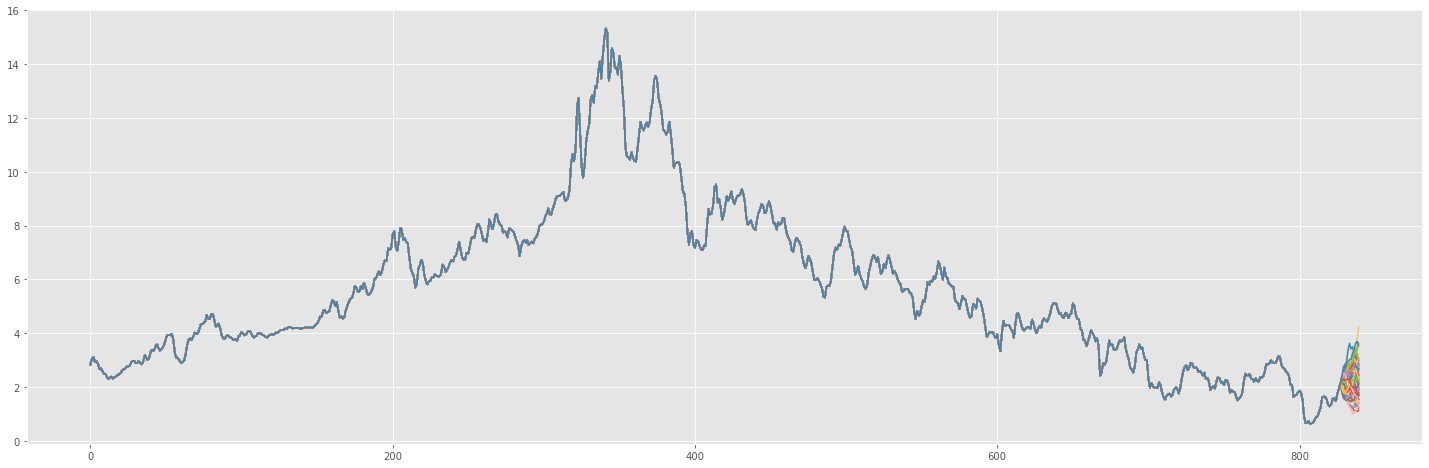

In [19]:
# simulacion invertiendo la boxcox

pdi_cols = []
for i in range(0,simulations):
    # la inversion de la funcoion ya no va sobre las nablas sino sobre las Transformaciones de las boxcox
    scenarios_df['pdi_'+str(i+1)] = list(box_cox_transform.inverse_transform(scenarios_df[[T_cols[i]]]).transpose()[0])
    pdi_cols.append('pdi_'+str(i+1))
scenarios_df[pdi_cols].plot(figsize=(25,8),legend=False)

P(PDI >=  3.5 )= 0.05


<AxesSubplot:>

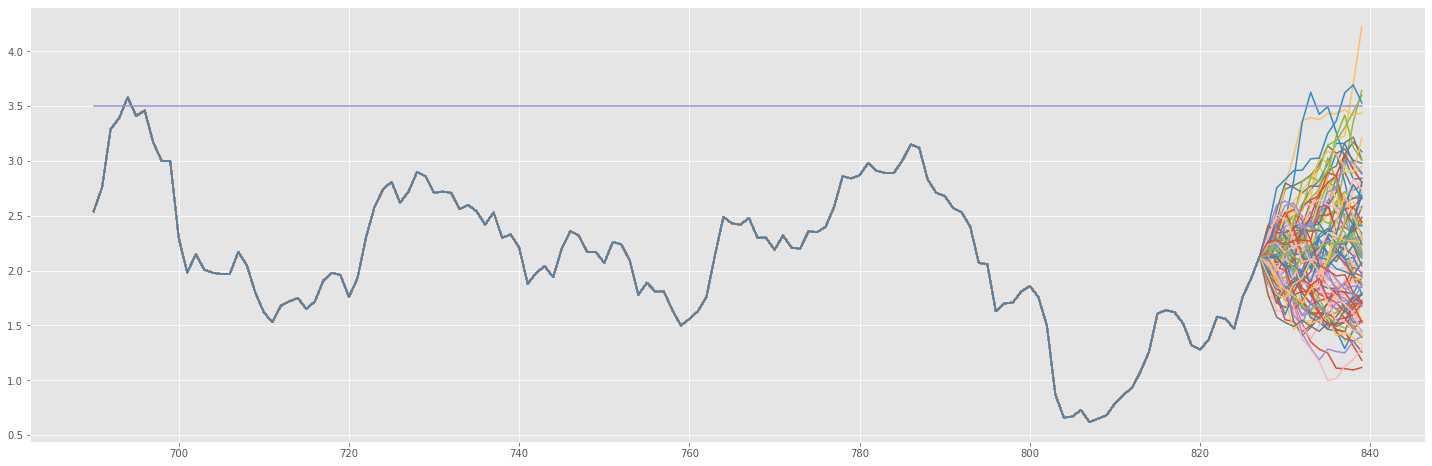

In [21]:
#queremos calcular que las futuras predicciones superen un 3.5% de interes en el mes de abril

limit = 3.5

# luego en probabilities (un df) haremos un conteo de de las simulaciones de que pasan el 3.5
# aquellas simulaciones que pasen el 3.5 les pondremos un uno 
probabilities_df = scenarios_df[scenarios_df['TIME']>='2022-03-01'][pdi_cols].copy()
flag_cols = []
for i in range(0,simulations):
    # aqui ponemos las banderas
    probabilities_df['flag_'+str(i)] = np.where(probabilities_df[pdi_cols[i]]>=limit,1,0)
    flag_cols.append('flag_'+str(i))

#conteo de unos entre el total de las simulaciones
proability = sum([1 for flag in probabilities_df[flag_cols].sum() if flag >= 1])/simulations
print('P(PDI >= ',limit,')=',proability) # numero de casos donde hay unos, entre el toltal se simulaciones

scenarios_df['limit'] = limit
scenarios_df[pdi_cols+['limit']].tail(150).plot(figsize=(25,8),legend=False)